<a href="https://colab.research.google.com/github/bernardcz/bcz/blob/master/3_street_grid_orientations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install `libspatialindex` -- run once per on startup

In [0]:
# Most basic tools we need are pre-installed in google colab. The tools for this exercise are not, so we need to do some extra setup. 
# Run this cell to install some necessary libraries. Then move on.
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz 2>/dev/null | tar xz
!apt-get install -qq g++ make
import os
os.chdir('/content/spatialindex-src-1.8.5')
!mount -o remount,exec /content
!./configure 2>&1 >/dev/null && make 2>&1 >/dev/null && make install && ldconfig
!pip install -q rtree

!pip install geopandas

!pip install osmnx

mount: /content: mount point not mounted or bad option.
./configure: line 6204: /usr/bin/file: No such file or directory
/content/spatialindex-src-1.8.5/missing: Unknown `--is-lightweight' option
Try `/content/spatialindex-src-1.8.5/missing --help' for more information
configure: WARNING: 'missing' script is too old or missing
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
ar: `u' modifier ignored since `D' is the default (see `U')
src/tools/.libs/libtools.a(Tools.o): In function `Tools::TemporaryFile::TemporaryFile()':
Tools.cc:(.text+0x3d35): warning: the use of `mktemp' is dangerous, better use `mkstemp' or `mkdtemp'
ar: `u' modifier ignored since `D' is the default (see `U')

## Assessing street grid orientations

In [0]:
# Now get the tools we need,as usual

from rtree import index
from rtree.index import Rtree
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# note that osmnx is the special tool here - it contains data on street networks and tools for analysing that data
import osmnx as ox
ox.config(log_console=True, use_cache=True)
weight_by_length = False

To compare street grid orientations, we start by choosing two cities. I've chosen Rome and Milan. If you've been to these cities, recall how the streets are organized. Are they laid out in neat parallel lines? Are there dominant directions in which the streets run?

In [0]:
# Here we are making a list using {} of all the places we want to study. We give a short name - or label - to each place name. 
# We use the format of 'label' : 'query' where the query is the full name of the place as written in our osmnx data source

places = {'Rome'       : 'Rome,Italy',
          'Milan'        : 'Milan,Italy'
          }

Now we can do a basic check of the data contained in our list of places

In [0]:
# create a geodataframe 'gdf' that lists the information from each of the places we've added to our list above
gdf = ox.gdf_from_places(places.values())
#type the name of the geodataframe to print it out
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,12.85576,42.141028,41.655642,12.234467,"MULTIPOLYGON (((12.23447 41.74005, 12.23459 41...","Rome, RM, Lazio, Italy"
1,9.27811,45.535848,45.386738,9.040887,"POLYGON ((9.04089 45.44745, 9.04093 45.44727, ...","Milan, Lombardy, Italy"


To analyse urban street orientations for one city, start by getting a polygon that describes the shape of a city. In this case, we're getting the data for Rome. We need to know the overall shape and spatial limits of the city to run this analysis.

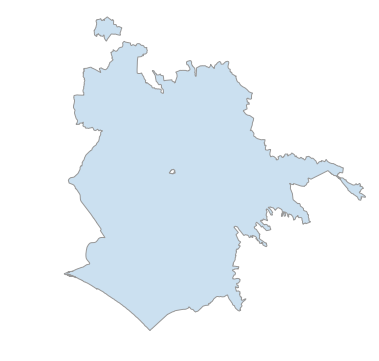

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50c95d8e10>)

In [0]:
#Get the data for Rome
city = ox.gdf_from_place('Rome, Italy')
#Plot the shape data on the map
ox.plot_shape(ox.project_gdf(city))

Now we need to consider how to check the orientation of a line. Imagine a straight vertical line. Does it run up (toward 0 on a circle) or down (toward 180 on a circle)? Of course, really it does both! To assess orientations we can decide that any street recorded as running down (values between 90 and 270 on a circle) will be reversed so that they are analysed as if they run up.

In [0]:
# reverse all downward running streets so they act as if they run up...
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

Next we will get the bearing, or main orientation, of each line representing a street in Rome

In [0]:
#define an empty set to hold information on all the bearings of the streets
bearings = {}
#for each city
for place in sorted(places.keys()):
    
    # get the graph of all the streets
    query = places[place]
    G = ox.graph_from_place(query, network_type='drive')
    
    # calculate edge bearings of the lines representing streets
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

Now we will count the number of streets with each orientation.

In [0]:
# here (and above and just below) you are defining a function, a little script that runs repeatedly on all your data

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

Finally, we will draw a diagram that shows the number of streets running along each orientation. 

We'll be using a type of diagram called a 'polar plot'.

Read about them [here](https://datavizproject.com/data-type/polar-area-chart/). 

In [0]:
# create a function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):
    
    #define bins to divide up the data
    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n
    # set north to 0 and work clockwise from there
    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')
    # set up colours, labels, and fonts for the diagram
    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Arial', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Arial', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Arial', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


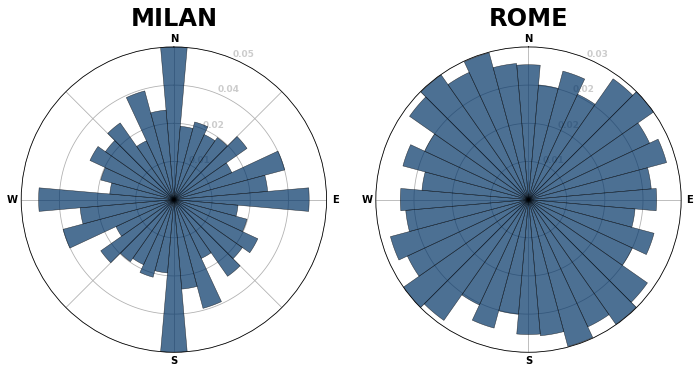

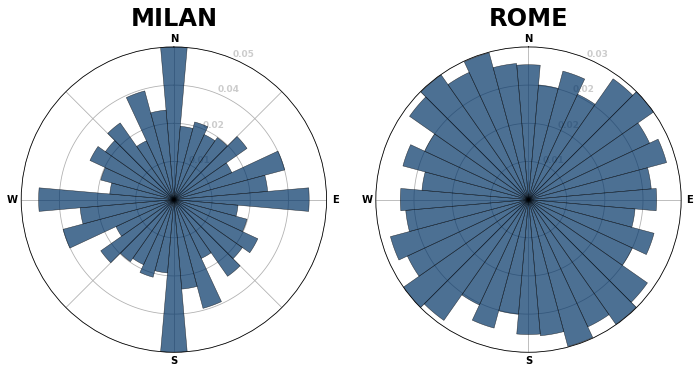

In [0]:
# create the figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image

fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig

Are the orientations seen here similar or different? What might you conclude about the development and organization from each city based on these diagrams?



Now that you've started thinking about orientation and how we might interpret it, head to the next notebook (linked from the moodle) for a slightly more in depth exercise.